In [5]:
from IPython.display import Audio
import torchaudio
from pathlib import Path
from torch import flatten
import matplotlib.pyplot as plt
from dataset import AudioDataset
import json
from utils import text2id, wav_read, wav_write, SNR_singlech
from tqdm import tqdm
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModelForCTC

In [2]:
MODEL_PATH = "facebook/wav2vec2-base-960h"
AUDIO_PATH = "/home/alekseevskaia/audio_attack/"

input_audio, sample_rate = torchaudio.load(AUDIO_PATH + "audio.wav")
Audio(input_audio, rate=sample_rate)

In [3]:
class CWAttack:
    def __init__(self, model, tokenizer, feature_extractor, vocab, steps = 1000, lr = 0.01, c = 1):
        self.model = model
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.steps = steps
        self.feature_extractor = feature_extractor
        self.lr = lr
        self.c = c
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.rescale = 200/32768  
    
    def get_distance(self, mode, x, y):
        if mode == 'l2':
            return torch.mean((x - y) ** 2, dim=1)

    def attack(self, target_text, ori_wav):
        ori_inputs = self.feature_extractor(ori_wav, sampling_rate=16000, return_tensors="pt").to(self.device)
        adv_inputs = self.feature_extractor(ori_wav, sampling_rate=16000, return_tensors="pt").to(self.device)
        adv_inputs["labels"] = torch.tensor(text2id(target_text,self.vocab))
        adv_inputs.input_values.requires_grad = True
        best_adv_wav = torch.tensor(np.array([ori_wav.copy()])).to(self.device)
        best_distance = torch.tensor([100]).cpu()

        optimizer = optim.Adam([adv_inputs.input_values], lr=self.lr)

        for step in range(self.steps):
            current_distance = self.get_distance('l2', adv_inputs.input_values, ori_inputs.input_values)
            outputs = self.model(**adv_inputs)
            cost = current_distance + self.c*outputs.loss
            cost = cost.to(self.device)

            pred_ids = torch.argmax(outputs.logits, dim=-1).cpu()
            pred_text = self.tokenizer.decode(torch.flatten(pred_ids), output_word_offsets=True)
            print('pred_text', pred_text[0])
            if (pred_text[0] == target_text):
                self.rescale *= 0.8
                if (current_distance.cpu() < best_distance.cpu()):
                    best_adv_wav = adv_inputs.input_values.clone()
                    best_distance = current_distance.cpu()
                    print("Get a success example!")
                    self.c = 0.2

            if(step % 100 == 0):
                print("steps ",step, " loss :", cost.item()," text: ", pred_text[0], " current distance: ", current_distance.item(), \
                        "rescale: ", self.rescale)

            optimizer.zero_grad()
            cost.backward(retain_graph=True)
            optimizer.step()
        return [best_adv_wav, adv_inputs.input_values]

In [4]:
steps = 5000
lr = 4/32768
c = 1
target_text = 'THIS TEXT BAD'

audio = wav_read(AUDIO_PATH + "audio.wav")
model = AutoModelForCTC.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_PATH)

with open('vocab.json', encoding='utf-8') as a:
    vocab = json.load(a)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
adv_audio = CWAttack(model, tokenizer, feature_extractor, vocab).attack(target_text, audio)

adv1 = adv_audio[0].cpu().detach().numpy()
adv_audio_wav = (adv1[0] * np.sqrt(audio.var() + 1e-7)) + audio.mean()
wav_write('adv_best.wav', adv_audio_wav)

adv2 = adv_audio[1].cpu().detach().numpy()
adv2_audio_wav = (adv2[0] * np.sqrt(audio.var() + 1e-7)) + audio.mean() 
wav_write('adv_final.wav', adv2_audio_wav)

# test the adversarial examples.
adv_audio = wav_read('adv_final.wav')
print("after read,the adv1 is :", adv_audio)
with torch.no_grad():
    adv_inputs = feature_extractor(adv_audio, sampling_rate=16000, return_tensors="pt").to(device)
    outputs = model(**adv_inputs)
    pred_ids = torch.argmax(outputs.logits, dim=-1).cpu()
    pred_text = tokenizer.decode(torch.flatten(pred_ids), output_word_offsets=True)
print('Transcription of adv:', pred_text[0])
snr = SNR_singlech(audio, adv_audio)
print('SNR is : ', snr)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

pred_text WITHOUT THE DAT ASSET THE ARTICLES USELESS
steps  0  loss : 327.4476013183594  text:  WITHOUT THE DAT ASSET THE ARTICLES USELESS  current distance:  0.0 rescale:  0.006103515625
pred_text WITHOUT TET THAT ASSET THE ARTIGRESS USELESS
pred_text BUT RATHER THAT IS AT THE ARTICLES EUSTACE
pred_text BUT GATHER THAT IS  THE ARTIGUASUSCUS
pred_text BUT RATHER THAT IS THE ARTIUASUSUS
pred_text LOOK RATHER THAT ISTHE ARTIASUSUS
pred_text B RATHER THAT IS THE ARTASUSS
pred_text RATHER THAT THE ARTUASUSS
pred_text RATHER THAT ISTHE ARTASUSS
pred_text RATHER THAT ISTHE ARTA UCS
pred_text RATHER THAT ISTHE ARTA UCIS
pred_text RATHER THAT THE ARTA UCS
pred_text RATHER THAT THE AR UC
pred_text RATHER THAT THE AR
pred_text RATHER THATTEAR
pred_text RATHER THATTEAR
pred_text RATHER THATTAR
pred_text RATHER THATTAR
pred_text RATHER THATAR
pred_text RAT THAT
pred_text A THAT
pred_text A THAT
pred_text A THAT
pred_text A THAT
pred_text ATHAT
pred_text ATHAT
pred_text THAT
pred_text THAT
pred_tex

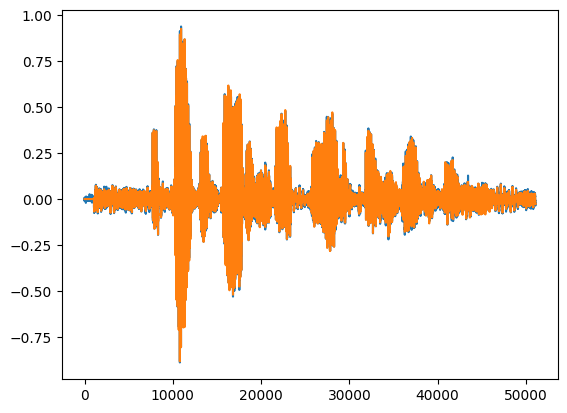

In [13]:
plt.plot(adv_audio)
plt.plot(audio)